In [1]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path

import sys, os
sys.path.append(os.path.abspath("../../.."))

from Forward.grav3D import grav3D_8091
from Forward.utils import calculateKernelGrav

In [4]:
# 1) Modelo

model_npz = np.load("../../../models/Toy1/Toy1_Grav.npz")

cell_centers = model_npz["cell_centers"].astype(np.float32)   # (nC, 3)
density_vol  = model_npz["grav_model"].astype(np.float32)     # (nC,)

density_contrast_flat = (density_vol.T) * 1000      # kg/m^3

dx = float(model_npz["dx"])
dy = float(model_npz["dy"])
dz = float(model_npz["dz"])

full_mesh = {"cell_centers": cell_centers, "dx": dx, "dy": dy, "dz": dz}

density_contrast_active = torch.as_tensor(density_contrast_flat, dtype=torch.float32)

# 2) Receptores
receivers_location = np.load("receivers_locationn.npz")
obs_xyz = receivers_location["receiver_locations"]


In [5]:
# 3) Kernel

kernelcal = calculateKernelGrav(
    density_contrast_model=density_contrast_active,
    mesh=full_mesh,
    receiver_locations=obs_xyz
)

In [6]:
# 4) Forward

gz_custom_mgal = grav3D_8091(
    density_contrast_model=density_contrast_active,
    K=kernelcal,
    to_mgal=True
)

data_torch = gz_custom_mgal.detach().cpu().numpy().ravel()
locs_torch = obs_xyz[:, :2]

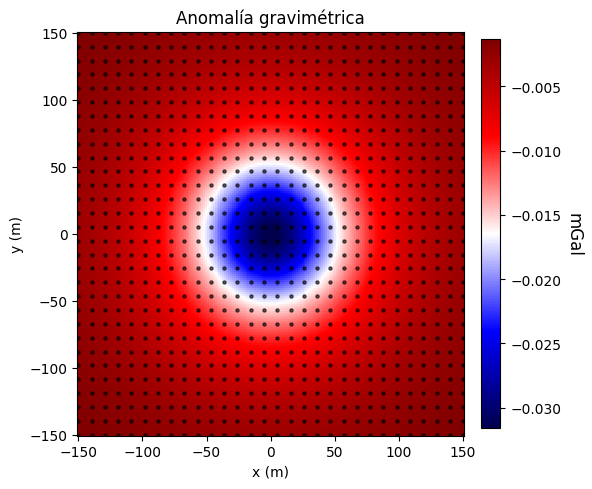

In [7]:
# 5) Plot

valid = np.isfinite(data_torch)
vmin_t, vmax_t = data_torch[valid].min(), data_torch[valid].max()
cmap = "seismic"

def plot_scattered_field(ax, locs, values, vmin, vmax, title, cmap="seismic", nx=200, ny=200):
    x, y = locs[:, 0], locs[:, 1]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(XI, YI, Zi, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    return im

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
mappable = plot_scattered_field(
    ax, locs_torch, data_torch,
    vmin=vmin_t, vmax=vmax_t,
    title="Anomalía gravimétrica",
    cmap=cmap
)

cbar = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mGal", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

In [8]:
x = obs_xyz[:, 0]
y = obs_xyz[:, 1]
gz = data_torch  

out = np.column_stack((x, y, gz))

np.savetxt(
    "AnomaliaResidual_Toy1.csv",
    out,
    delimiter=",",
    header="x,y,gz_mGal",
    comments=""
)